In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.pipeline import Pipeline
from warnings import filterwarnings
import matplotlib.pyplot as plt

# todo: explain how to pip install DatasetsEvaluator, point to github page

# todo: put back when done -- update datasets evaluator on pypi and retest -- i added the drop=True
#from DatasetsEvaluator import DatasetsEvaluator as de

# Todo: remove once have pip install
import sys  
sys.path.insert(0, 'C:\python_projects\RotationFeatures_project\RotationFeatures')
from RotationFeatures import RotationFeatures # todo: fix once have pip install

sys.path.insert(0, 'C:\python_projects\DatasetsEvaluator_project\DatasetsEvaluator')
import DatasetsEvaluator as de

filterwarnings('ignore')
np.random.seed(0)

In [2]:
cache_folder = "c:\dataset_cache"
partial_result_folder = "c:\\intermediate_results"

## Constants Used to Control the Tests Below

In [3]:
# These specify how many datasets are used in the tests below. Ideally about 50 to 100 datasets would be used,
# but these may be set lower. Set to 0 to skip tests. 

NUM_DATASETS_CLASSIFICATION_DEFAULT = 0
NUM_DATASETS_REGRESSION_DEFAULT = 0
NUM_DATASETS_CLASSIFICATION_GRID_SEARCH = 2
NUM_DATASETS_REGRESSION_GRID_SEARCH = 0

# Classification Tests -- With Default Parameters

## Define the set of datasets on openml we will test against

In [4]:
datasets_tester = de.DatasetsTester()

matching_datasets = datasets_tester.find_datasets( 
    problem_type = "classification",
    min_num_classes = 2,
    max_num_classes = 20,
    min_num_minority_class = 5,
    max_num_minority_class = np.inf,
    min_num_features = 0,
    max_num_features = np.inf,
    min_num_instances = 500,
    max_num_instances = 5_000,
    min_num_numeric_features = 2,
    max_num_numeric_features = 50,
    min_num_categorical_features=0,
    max_num_categorical_features=50)

## Collect the datasets and run the tests

In [5]:
# todo: get this working, then update datasetsEvaluator & this on github & pypi
datasets_tester.collect_data(max_num_datasets_used=NUM_DATASETS_CLASSIFICATION_DEFAULT, 
                             preview_data=False, 
                             save_local_cache=True,
                             check_local_cache=True,
                             path_local_cache=cache_folder)
 

In [6]:
pipe1 = Pipeline([('dt', tree.DecisionTreeClassifier(random_state=0))])
pipe2 = Pipeline([('rota', RotationFeatures()), ('dt', tree.DecisionTreeClassifier(random_state=0))])

# This provides an example using some non-default parameters. 
summary_df = datasets_tester.run_tests(estimators_arr = [
                                        ("DT", "Original Features", "Default", pipe1),
                                        ("DT", "Rotation-based Features", "Default", pipe2)],
                                       num_cv_folds=3,
                                       show_warnings=False,
                                       partial_result_folder=partial_result_folder) 

display(summary_df)


Running test on 0 datastets


,Dataset Index,Dataset,Dataset Version,Model,Feature Engineering Description,Hyperparameter Description,Avg f1_macro,Std dev between folds,Train-Test Gap,# Columns,Model Complexity,Fit Time


## Summarize the results in a table

In [7]:
def summarize_results(accuracy_metric, show_std_dev=False):
    if (len(summary_df)==0):
        return
    p = pd.DataFrame(summary_df.groupby(['Model', 'Feature Engineering Description'])[accuracy_metric].mean())
    if (show_std_dev):
        p['Avg. Std dev between folds'] = summary_df.groupby(['Model', 'Feature Engineering Description'])['Std dev between folds'].mean()
    p['Avg. Train-Test Gap'] = summary_df.groupby(['Model', 'Feature Engineering Description'])['Train-Test Gap'].mean()
    p['Avg. Fit Time'] = summary_df.groupby(['Model', 'Feature Engineering Description'])['Fit Time'].mean()
    p['Avg. Complexity'] = summary_df.groupby(['Model', 'Feature Engineering Description'])['Model Complexity'].mean()
    display(p)    

c:\users\aymke\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
summarize_results('Avg f1_macro')

## Graph the Results

In [9]:
def plot_results(summary_df, accuracy_metric):
    if (len(summary_df)==0):
        return
    
    # Collect the set of all combinations of model type and feature engineering. In this example, there
    # should just be the two.
    combinations_df = summary_df.groupby(['Model', 'Feature Engineering Description']).size().reset_index()

    summary_df = summary_df.dropna(subset=[accuracy_metric])

    # Draw a single plot, with a line for each feature engineering description. Along the x-axis we have each
    # dataset ordered by lowest to highest score when using the original features. 
    fig_width = min(len(summary_df)/4, 20)
    fig_width = max(fig_width, 5)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_width,5))
    for row_idx in range(len(combinations_df)):
        m = combinations_df.iloc[row_idx]['Model']
        h = combinations_df.iloc[row_idx]['Feature Engineering Description']

        # Get the subset of summary_df for the current feature engineering method. 
        if (row_idx==0):
            subset_df_1 = summary_df[(summary_df['Model']==m) & (summary_df['Feature Engineering Description']==h)].sort_values(by=accuracy_metric).reset_index()
            x_coords = subset_df_1.index        
            y_coords = subset_df_1[accuracy_metric]
        else:
            subset_df_2 = summary_df[(summary_df['Model']==m) & (summary_df['Feature Engineering Description']==h)]
            y_coords = []
            for i in range(len(subset_df_1)):
                ds = subset_df_1.iloc[i]['Dataset']
                y_coords.append(subset_df_2[subset_df_2['Dataset']==ds][accuracy_metric])
        ax.plot(x_coords, y_coords, label=m + "(" + h + ")")
    t = subset_df_1['Dataset']
    plt.xticks(range(len(t)), t, size='small', rotation=55)            
    plt.legend()
    plt.title(accuracy_metric + " by dataset")
    plt.show()

In [10]:
plot_results(summary_df, 'Avg f1_macro')

## 2nd Classification Test -- Holding the tree depth to 5

In [11]:
pipe1 = Pipeline([('dt', tree.DecisionTreeClassifier(max_depth=5, random_state=0))])
pipe2 = Pipeline([('rota', RotationFeatures()), ('dt', tree.DecisionTreeClassifier(max_depth=5, random_state=0))])

# This provides an example using some non-default parameters. 
summary_df = datasets_tester.run_tests(estimators_arr = [
                                        ("DT", "Original Features", "Default", pipe1),
                                        ("DT", "Rotation-based Features", "Default", pipe2)],
                                       num_cv_folds=3,
                                       show_warnings=False,
                                       partial_result_folder=partial_result_folder) 

display(summary_df)


Running test on 0 datastets


,Dataset Index,Dataset,Dataset Version,Model,Feature Engineering Description,Hyperparameter Description,Avg f1_macro,Std dev between folds,Train-Test Gap,# Columns,Model Complexity,Fit Time


In [12]:
summarize_results('Avg f1_macro')

c:\users\aymke\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
plot_results(summary_df, 'Avg f1_macro')

# Regression Tests - With Default Parameters

In [14]:
datasets_tester = de.DatasetsTester()

matching_datasets = datasets_tester.find_datasets( 
    problem_type = "regression",
    min_num_features = 0,
    max_num_features = np.inf,
    min_num_instances = 500,
    max_num_instances = 5_000,
    min_num_numeric_features = 2,
    max_num_numeric_features = 50,
    min_num_categorical_features=0,
    max_num_categorical_features=50)

In [15]:
datasets_tester.collect_data(max_num_datasets_used=NUM_DATASETS_REGRESSION_DEFAULT, 
                             preview_data=False, 
                             save_local_cache=True,
                             check_local_cache=True,
                             path_local_cache=cache_folder)
 

pipe1 = Pipeline([('dt', tree.DecisionTreeRegressor(random_state=0))])
pipe2 = Pipeline([('rota', RotationFeatures()), ('dt', tree.DecisionTreeRegressor(random_state=0))])

summary_df = datasets_tester.run_tests(estimators_arr = [
                                        ("DT", "Original Features", "Default", pipe1),
                                        ("DT", "Rotation-based Features", "Default", pipe2)],
                                       num_cv_folds=3,
                                       show_warnings=True,
                                       partial_result_folder=partial_result_folder) 

display(summary_df)


Running test on 0 datastets


c:\users\aymke\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dataset Index,Dataset,Dataset Version,Model,Feature Engineering Description,Hyperparameter Description,Avg NRMSE,Std dev between folds,Train-Test Gap,# Columns,Model Complexity,Fit Time


In [16]:
summarize_results('Avg NRMSE')

c:\users\aymke\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
plot_results(summary_df, 'Avg NRMSE')

## 2nd Regression Test -- Holding the tree depth to 5

In [18]:
pipe1 = Pipeline([('dt', tree.DecisionTreeRegressor(max_depth=5, random_state=0))])
pipe2 = Pipeline([('rota', RotationFeatures()), ('dt', tree.DecisionTreeRegressor(max_depth=5, random_state=0))])

summary_df = datasets_tester.run_tests(estimators_arr = [
                                        ("DT", "Original Features", "Default", pipe1),
                                        ("DT", "Rotation-based Features", "Default", pipe2)],
                                       num_cv_folds=3,
                                       show_warnings=True,
                                       partial_result_folder=partial_result_folder) 

display(summary_df)


Running test on 0 datastets


,Dataset Index,Dataset,Dataset Version,Model,Feature Engineering Description,Hyperparameter Description,Avg NRMSE,Std dev between folds,Train-Test Gap,# Columns,Model Complexity,Fit Time


In [19]:
summarize_results('Avg NRMSE')

c:\users\aymke\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
plot_results(summary_df, 'Avg NRMSE')

# Classification Tests -- Using CVGridSearch to determine the hyperparameters

In [21]:
# As this takes much longer than testing with the default parameters, we test with fewer datasets. Note though,
# run_tests_grid_search() uses CV to evaluate the grid search for the best hyperparameters, it does a train-test 
# split on the data for evaluation, so evaluates the predictions quickly, though with more variability than if
# using CV to evaluate as well. 

# todo: display the best hyperparameters too

datasets_tester = de.DatasetsTester()

matching_datasets = datasets_tester.find_datasets(problem_type = "classification", 
                                                  min_num_numeric_features=2,
                                                  max_num_numeric_features=10) # Set lower to be faster
display(matching_datasets)

datasets_tester.collect_data(max_num_datasets_used=NUM_DATASETS_CLASSIFICATION_GRID_SEARCH, 
                             exclude_list=['breast-w'],
                             preview_data=False, 
                             save_local_cache=True,
                             check_local_cache=True,
                             path_local_cache=cache_folder)

orig_parameters = {
     'dt__max_depth': (3,4,5,6,100)
}

rota_parameters = {
    'rota__degree_increment': (3,4,10,15,30), 
#     'dt__max_depth': (3,4,5,6)
}

orig_pipe = Pipeline([('dt', tree.DecisionTreeClassifier())])
rota_pipe = Pipeline([('rota', RotationFeatures()), ('dt', tree.DecisionTreeClassifier())])

# This provides an example using some non-default parameters. 
summary_df = datasets_tester.run_tests_grid_search(
        estimators_arr = [
            ("DT", "Original Features", "", orig_pipe),
            ("DT", "Rotation-based Features", "", rota_pipe)],
        parameters_arr=[orig_parameters, rota_parameters],
        num_cv_folds=3,
        show_warnings=False,
        partial_result_folder=partial_result_folder) 

display(summary_df)


,did,name,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
2,2,anneal,1,1,active,ARFF,684.0,7.0,8.0,5.0,39.0,898.0,898.0,22175.0,6.0,33.0
11,11,balance-scale,1,1,active,ARFF,288.0,3.0,49.0,3.0,5.0,625.0,0.0,0.0,4.0,1.0
15,15,breast-w,1,1,active,ARFF,458.0,2.0,241.0,2.0,10.0,699.0,16.0,16.0,9.0,1.0
18,18,mfeat-morphological,1,1,active,ARFF,200.0,10.0,200.0,10.0,7.0,2000.0,0.0,0.0,6.0,1.0
23,23,cmc,1,1,active,ARFF,629.0,4.0,333.0,3.0,10.0,1473.0,0.0,0.0,2.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40713,40713,dis,1,869,active,ARFF,3714.0,5.0,58.0,2.0,30.0,3772.0,0.0,0.0,6.0,24.0
40945,40945,Titanic,1,2,active,ARFF,809.0,3.0,500.0,2.0,14.0,1309.0,1309.0,3855.0,6.0,3.0
40981,40981,Australian,4,4265,active,ARFF,383.0,14.0,307.0,2.0,15.0,690.0,0.0,0.0,6.0,9.0
40983,40983,wilt,2,4265,active,ARFF,4578.0,2.0,261.0,2.0,6.0,4839.0,0.0,0.0,5.0,1.0


Reading from local cache: 1, id: 29, name: credit-approval
Reading from local cache: 2, id: 31, name: credit-g

Running test on 2 datastets
Running tests on dataset: 0: credit-approval
	Running tests with model: DT (Original Features)
	test_score:  0.8381016042780749
	Running tests with model: DT (Rotation-based Features)
	test_score:  0.7293197278911565
Running tests on dataset: 1: credit-g
	Running tests with model: DT (Original Features)
	test_score:  0.6381578947368421
	Running tests with model: DT (Rotation-based Features)
	test_score:  0.5965017641318219


,Dataset Index,Dataset,Dataset Version,Model,Feature Engineering Description,Hyperparameter Description,f1_macro,Train-Test Gap,# Columns,Model Complexity,Fit Time
0,0,credit-approval,1,DT,Original Features,,0.838102,0.026355,55,15.0,0.23
1,0,credit-approval,1,DT,Rotation-based Features,,0.729320,0.270680,55,107.0,212.86
2,1,credit-g,1,DT,Original Features,,0.638158,0.137828,74,91.0,0.23
3,1,credit-g,1,DT,Rotation-based Features,,0.596502,0.403498,74,223.0,307.92


In [22]:
summarize_results('f1_macro', show_std_dev=False)

c:\users\aymke\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


f1_macro  Avg. Train-Test Gap  \
Model Feature Engineering Description                                  
DT    Original Features                0.738130             0.082092   
      Rotation-based Features          0.662911             0.337089   

                                       Avg. Fit Time  Avg. Complexity  
Model Feature Engineering Description                                  
DT    Original Features                         0.23             53.0  
      Rotation-based Features                 260.39            165.0

c:\users\aymke\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


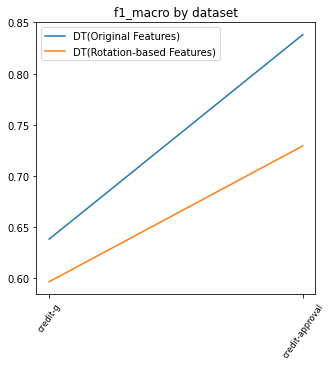

In [23]:
plot_results(summary_df, 'f1_macro')

## Regression Tests -- Using CVGridSearch to determine the hyperparameters

In [24]:
# As this takes much longer than testing with the default parameters, we test with fewer datasets. Note though,
# run_tests_grid_search() uses CV to evaluate the grid search for the best hyperparameters, it does a train-test 
# split on the data for evaluation, so evaluates the predictions quickly, though with more variability than if
# using CV to evaluate as well. 


# todo: display the best hyperparameters too

datasets_tester = de.DatasetsTester()

matching_datasets = datasets_tester.find_datasets(problem_type = "regression",
                                                  min_num_numeric_features=2,
                                                  max_num_numeric_features=10)

datasets_tester.collect_data(max_num_datasets_used=NUM_DATASETS_REGRESSION_GRID_SEARCH, 
                             preview_data=False, 
                             save_local_cache=True,
                             check_local_cache=True,
                             path_local_cache=cache_folder)

orig_parameters = {
     'dt__max_depth': (3,4,5,6)
}

rota_parameters = {
     'rota__degree_increment': (3,4,10,15,30),
     'dt__max_depth': (3,4,5,6)
}

orig_pipe = Pipeline([('dt', tree.DecisionTreeClassifier())])
rota_pipe = Pipeline([('rota', RotationFeatures()), ('dt', tree.DecisionTreeClassifier())])

# This provides an example using some non-default parameters. 
summary_df = datasets_tester.run_tests_grid_search(
        estimators_arr = [
            ("DT", "Original Features", "", orig_pipe),
            ("DT", "Rotation-based Features", "", rota_pipe)],
        parameters_arr=[orig_parameters, rota_parameters],
        num_cv_folds=3,
        show_warnings=False,
        partial_result_folder=partial_result_folder) 

display(summary_df)

c:\users\aymke\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Running test on 0 datastets


,Dataset Index,Dataset,Dataset Version,Model,Feature Engineering Description,Hyperparameter Description,NRMSE,Train-Test Gap,# Columns,Model Complexity,Fit Time


In [25]:
summarize_results('Avg NRMSE')

c:\users\aymke\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
plot_results(summary_df, 'Avg NRMSE')